In [1]:
import sys
sys.path.append('../')
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
from effdet.data.cap_multi_aug import *
from bboxVisualize import *
from effdet.data.transforms import *

In [2]:
img_path = 'path/to/images/'
ann_files = "path/to/annotations"
coco = COCO(ann_files+'val.json')
category_id_to_name = getCategoryIdToName(coco)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


((756, 483),
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=756x483 at 0x1F0A3BFDD30>)

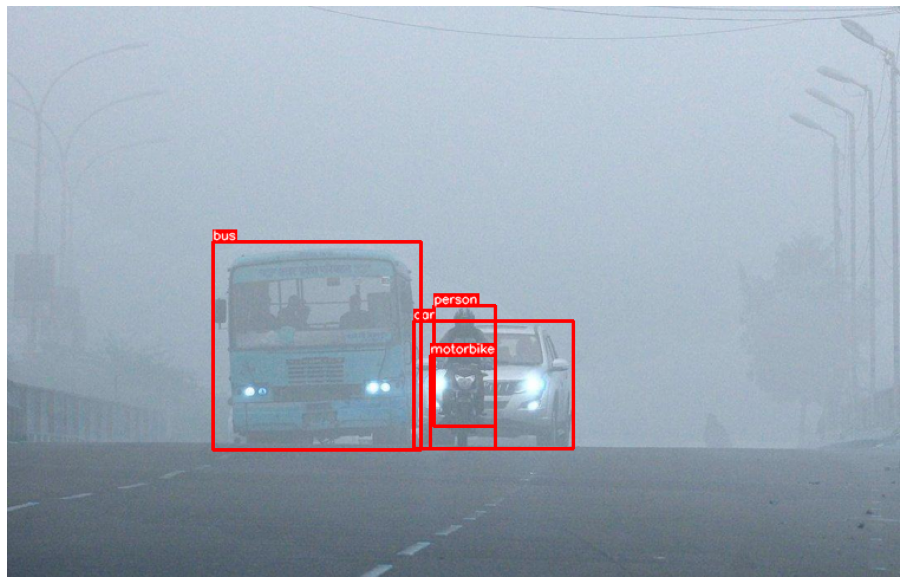

In [3]:
imginfo = coco.loadImgs([2])[0]
imginfo
annotations = getAnnotFromImgIds(coco,[imginfo['id']],toYxyx=True)[0]
annotations
cvimg = cv2.imread(img_path+imginfo['file_name'])
visualizeFromAnnots(cvimg,annotations,category_id_to_name,toXywh=True)
img = Image.open(img_path+imginfo['file_name'])
img.size,img

(3, 512, 512)
{'bbox': array([[156.29778211, 223.01778396, 219.31111719, 255.1422293 ],
       [182.2444495 , 221.16445058, 231.0488953 , 255.1422293 ],
       [164.32889345, 212.51556145, 231.0488953 , 295.91556376],
       [122.93778119, 107.49333631, 231.66667309, 216.22222822]]), 'cls': array([2, 4, 1, 3], dtype=int64), 'img_scale': 1.6187049910898759}


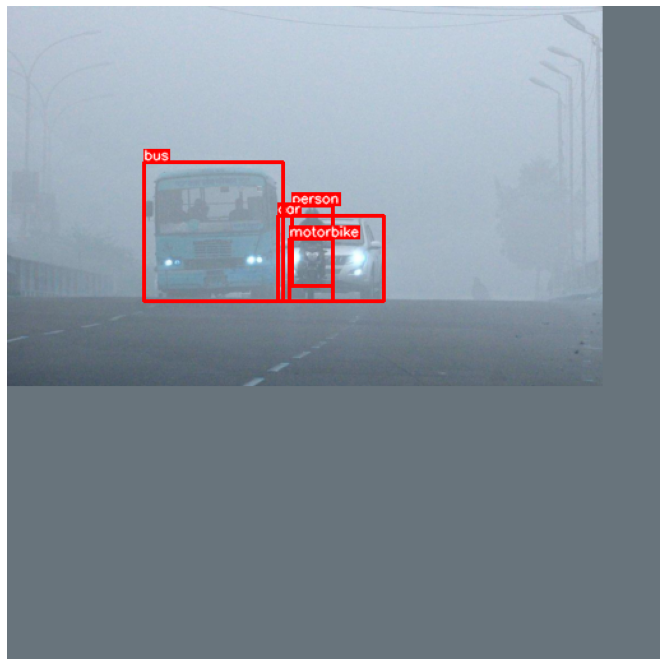

In [13]:
image_tf = transforms_coco_train(img_size=512,use_prefetcher=True, mode='aug')
annotations = getAnnotFromImgIds(coco,[imginfo['id']],toYxyx=True)[0]
new_img2, new_ann2 = image_tf(img, annotations)
print(new_img2.shape)
print(new_ann2)
new_img2_PIL = Image.fromarray(np.transpose(new_img2,(1,2,0)))
new_img2_cv = cv2.cvtColor(np.transpose(new_img2,(1,2,0)),cv2.COLOR_BGR2RGB)#,cv2.COLOR_RGB2BGR)
visualizeFromAnnots(new_img2_cv,new_ann2,category_id_to_name,toXywh=True)

In [7]:
# try different albumentation methods
train_transforms = A.Compose([
        # A.RandomSizedBBoxSafeCrop(img_size[0], img_size[1], p=1.0),
        A.HorizontalFlip(p=0.5),
        # CAP_Albu(p=0.5,
        #          source_images=SOURCE_IMAGES,
        #          n_objects_range=[1, 3],
        #          random_h_flip=True),
        # A.ShiftScaleRotate(shift_limit=0, scale_limit=0.5, rotate_limit=0, p=0.5),
        # A.RandomScale(scale_limit=0.5, p=1.0),
        A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=1),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                ], p=0.5),
        A.OneOf([
                A.MedianBlur(blur_limit=3, p=1.0),
                A.Blur(blur_limit=3, p=1.0),
                ], p=0.5),
        A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
        # A.Cutout(num_holes=8, max_h_size=int(0.1*img_size[0]), max_w_size=int(0.1*img_size[1]), fill_value=mean, p=0.5),
    ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,  # drop bbox that smaller than 100 pixels
            min_visibility=0,
            label_fields=['labels']
    ))

In [16]:
# try different augmentation methods
image_tfl = [
    RandomResizePad(
        target_size=img_size, scale=(0.5, 2.0), interpolation=interpolation, fill_color=fill_color),
    # RandomFlip(horizontal=True, prob=0.5),
    ImageToNumpy(),
    Albu(train_transforms),
    # copy and paste augmentation using objects pictures
    # cap_aug(n_objects_range=[3, 3], glob_split='_', p=0.5,
    #         retry_iters=20, min_inter_area=100, glob_suffix='*.png'),
    # bbox copy and paste augmentation
    bboxCapAug(thresh=32*32, prob=0.8, copy_times=3, epochs=30, all_objects=False, one_object=False),
    HWC2CHW()
]
image_tf = Compose(image_tfl)

{'bbox': array([[ 96.14632515, 137.18902522, 134.90887521, 156.95032525],
       [112.10737518, 136.04895022, 142.12935023, 156.95032525],
       [101.08665016, 130.72860021, 142.12935023, 182.03197529],
       [ 75.62497512,  66.1243501 , 142.50937523, 133.00875021],
       [312.        , 100.        , 342.        , 120.        ],
       [222.        , 290.        , 252.        , 310.        ],
       [256.        , 327.        , 286.        , 347.        ]]), 'cls': array([2., 4., 1., 3., 4., 4., 4.]), 'img_scale': 2.631405824390541}


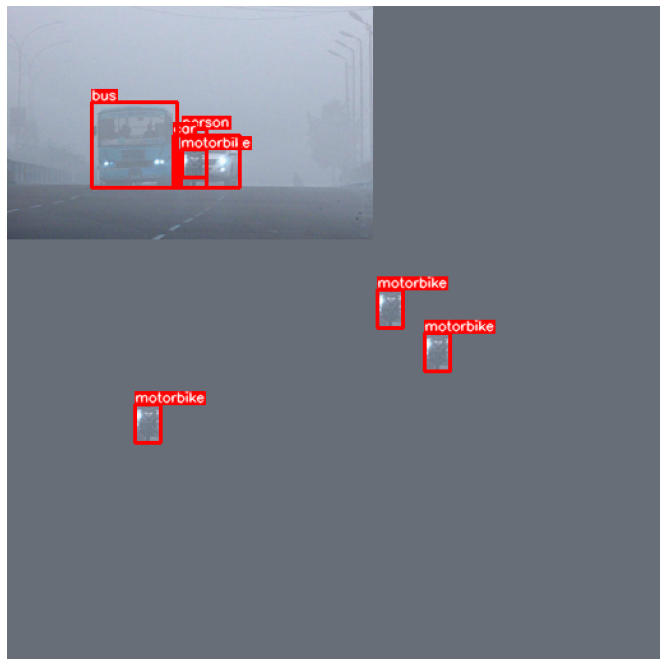

In [22]:
annotations = getAnnotFromImgIds(coco,[imginfo['id']],toYxyx=True)[0]
new_img2, new_ann2 = image_tf(img, annotations)
print(new_ann2)
new_img2_PIL = Image.fromarray(np.transpose(new_img2,(1,2,0)))
new_img2_cv = cv2.cvtColor(np.transpose(new_img2,(1,2,0)),cv2.COLOR_BGR2RGB)#,cv2.COLOR_RGB2BGR)
visualizeFromAnnots(new_img2_cv,new_ann2,category_id_to_name,toXywh=True)